# Machine Learning Group Project - Group 50
## Masters in Data Science and Advanced Analytics at NOVA IMS, Lisbon

## Group Information
Group members: **<span style="color:red">(Everyone please check and correct the names)</span><br>**
Md. Shawkatul Islam Aziz<br>
Md. Tahir Hossain<br>
Philipp Metzger<br>
Ali Sabbir<br>
Henrique Vaz<br>

## Import all libraries needed

In [94]:
import os
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
import time
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

## Load the data

In [2]:
train = pd.read_excel(os.path.join('Data', 'Train.xlsx'), sheet_name='Sheet1')
test = pd.read_excel(os.path.join('Data', 'Test.xlsx'), sheet_name='Sheet1')

## First exploration of the training set

In [3]:
# Show the first three rows of 'train'
train.head(3)

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1


In [4]:
# Get the dimensions of 'train'
train.shape

(22400, 15)

In [5]:
# Check the data types and check if there are missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22400 entries, 0 to 22399
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CITIZEN_ID              22400 non-null  int64 
 1   Name                    22400 non-null  object
 2   Birthday                22400 non-null  object
 3   Native Continent        22400 non-null  object
 4   Marital Status          22400 non-null  object
 5   Lives with              22400 non-null  object
 6   Base Area               22400 non-null  object
 7   Education Level         22400 non-null  object
 8   Years of Education      22400 non-null  int64 
 9   Employment Sector       22400 non-null  object
 10  Role                    22400 non-null  object
 11  Working Hours per week  22400 non-null  int64 
 12  Money Received          22400 non-null  int64 
 13  Ticket Price            22400 non-null  int64 
 14  Income                  22400 non-null  int64 
dtypes:

In [6]:
# Get the basic descriptive statistics on 'train'
train.describe()

,CITIZEN_ID,Years of Education,Working Hours per week,Money Received,Ticket Price,Income
count,22400.000000,22400.000000,22400.000000,22400.000000,22400.000000,22400.000000
mean,23685.500000,13.173884,40.483795,1324.915357,109.145313,0.237098
std,6466.467351,2.512451,12.370921,9227.771813,500.208904,0.425313
min,12486.000000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,18085.750000,12.000000,40.000000,0.000000,0.000000,0.000000
50%,23685.500000,13.000000,40.000000,0.000000,0.000000,0.000000
75%,29285.250000,15.000000,45.000000,0.000000,0.000000,0.000000
max,34885.000000,21.000000,99.000000,122999.000000,5358.000000,1.000000


In [7]:
# Find out the share of individuals with income higher than average and lower than average
higher = len(train.Income[train.Income==1])
lower = len(train.Income[train.Income==0])

percentage_higher = higher / len(train.Income) * 100
percentage_lower = lower / len(train.Income) * 100

print(round(percentage_higher,2), '% in the training set have a higher than average income.')
print(round(percentage_lower,2), '% in the training set have a lower than average income.')

23.71 % in the training set have a higher than average income.
76.29 % in the training set have a lower than average income.


## Transform 'Birthday' to datetime format and get the age in days relative to today

In [8]:
# Define a function that maps month names to their integers

def monthToInt(monthStr):

    return {
            'January' : 1,
            'February' : 2,
            'March' : 3,
            'April' : 4,
            'May' : 5,
            'June' : 6,
            'July' : 7,
            'August' : 8,
            'September' : 9, 
            'October' : 10,
            'November' : 11,
            'December' : 12
    }[monthStr]

In [9]:
# Define a function that checks if a year is a leap year
# Adapted from:
# https://www.programiz.com/python-programming/examples/leap-year

# "A leap year is exactly divisible by 4 except for century years (years ending with 00). 
# The century year is a leap year only if it is perfectly divisible by 400."

def is_leapyear(year):
    if (year % 4) == 0:
        if (year % 100) == 0:
            if (year % 400) == 0:
                return True
            else:
                return False
        else:
            return True
    else:
        return False

In [10]:
# Define a function that takes the information from column 'Birthday' and adds a column that contains the
# birthdays as datetime objects and another column that contains the age of the person in days relative to today (2020)

def add_Birthday_date_Age_days_rel_to_2020(df):
    
    # Make a copy
    df_copy = df.copy()
    
    # Get the year, month and day from Strings in 'Birthday'
    split = df_copy.Birthday.str.split(',', expand=True)
    year = split.iloc[:,1].astype(int)
    month_day = split.iloc[:,0].str.strip(to_strip=' ').str.split(' ', expand=True)
    day = month_day.iloc[:,1].astype(int)
    month = month_day.iloc[:,0]
    
    # Map month names to integers
    month = month.map(lambda x:monthToInt(x))
    
    # Build a dataframe containing the date values
    frame = {'year':year, 'month':month, 'day':day}
    birthday = pd.DataFrame(frame)
    
    # Create datetime objects from the date values
    # Some problems with leap years (see below)
    birthday_date = []
    for i in range(birthday.shape[0]):
    
        # Get the values for this row
        year_i = int(birthday.iloc[i,0])
        month_i = int(birthday.iloc[i,1])
        day_i = int(birthday.iloc[i,2])

        # Leap years are incorrectly defined for this dataset.
        # For example row 359: year 2022, month 2, day 29 is a birthday in this datase, but in reality it does not 
        # exist.
        # -> Decrease all days where month=2 and day=29 that aren't in a leap year by 1 day to be able to use 
        # datetime.date

        # Get True if this year is a leap year, else False
        leapyear = is_leapyear(year_i)

        if (~leapyear and month_i==2 and day_i==29):
            day_i = day_i - 1
        date = datetime.date(year_i, month_i, day_i)
        birthday_date.append(date)
        
    # Convert the list to a pandas series
    birthday_date = pd.Series(birthday_date)
    
    # Insert 'birthday_date' as new column 'Birthday_date'
    df_copy.insert(loc=3, column='Birthday_date', value=birthday_date)
    
    # Compute time differences to today (2020) and keep only the value in days
    now = date.today()
    age = now - df_copy.Birthday_date
    age_days = age.dt.days
    
    # Insert 'age_days' as 'Age_days_rel_to_2020'
    df_copy.insert(loc=4, column='Age_days_rel_to_2020', value=age_days)
    
    # Return the resulting dataframe
    return df_copy

In [11]:
# Use the function defined above to add columns 'Birthday_date' and 'Age_days_rel_to_2020' to 'train'
train_2 = add_Birthday_date_Age_days_rel_to_2020(train)

In [12]:
# For later (Outlier detection): Save 'Birthday_date' is a new variable 'birthdays'
birthdays = train_2['Birthday_date']

In [13]:
# Drop columns 'Birthday' and 'Birthday_date'
train_2 = train_2.drop(columns=['Birthday', 'Birthday_date'])

In [14]:
# Check the result
train_2.head(3)

,CITIZEN_ID,Name,Age_days_rel_to_2020,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,6360,Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,5421,Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,4220,Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1


In [15]:
# Save 'train_2'as our new version
train = train_2

## Compute and visualise the correlations between the metric features and the target

In [16]:
# Define metric features and target in one list
metric_features_and_target = ['Age_days_rel_to_2020','Years of Education','Working Hours per week','Money Received','Ticket Price','Income']

In [17]:
# Compute the correlation matrix of 'train'
corr_pearson = train_2[metric_features_and_target].corr(method='pearson')
corr_spearman = train_2[metric_features_and_target].corr(method='spearman')

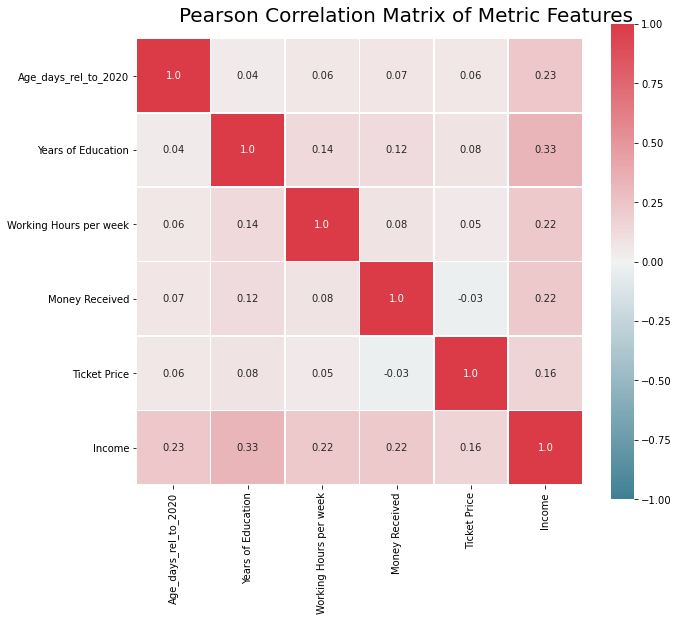

In [18]:
# Adapted from data mining lab 4:

# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Round the values of the correlation matrix
corr_rounded = np.round(corr_pearson, decimals=2)

# Build annotation matrix (values above |limit| will appear annotated in the plot)
limit=0.001
mask_annot = np.absolute(corr_rounded.values) >= limit
annot = np.where(mask_annot, corr_rounded.values, np.full(corr_rounded.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr_rounded, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Pearson Correlation Matrix of Metric Features", fontsize=20)

plt.show()

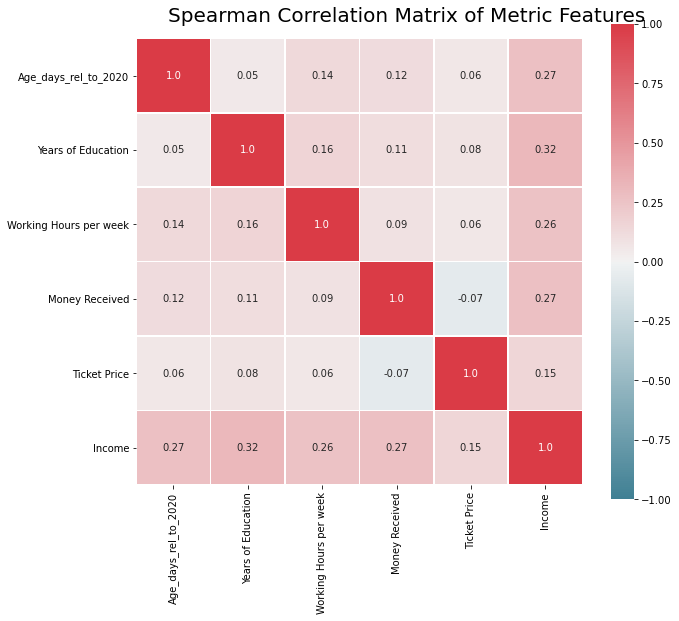

In [19]:
# Adapted from data mining lab 4:

# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Round the values of the correlation matrix
corr_rounded = np.round(corr_spearman, decimals=2)

# Build annotation matrix (values above |limit| will appear annotated in the plot)
limit=0.001
mask_annot = np.absolute(corr_rounded.values) >= limit
annot = np.where(mask_annot, corr_rounded.values, np.full(corr_rounded.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr_rounded, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Spearman Correlation Matrix of Metric Features", fontsize=20)

plt.show()

## Assessing the discriminatory power of the categorical features

In [20]:
# Adapted from Machine learning lab "Feature Selection"
def bar_charts_categorical(df, feature, target, rotation):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    ax1 = plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.setp(ax1.get_xticklabels(), rotation=rotation, horizontalalignment='right')
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    ax2 = plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.setp(ax2.get_xticklabels(), rotation=rotation, horizontalalignment='right')
    plt.ylabel("$p$")

    plt.show()

### Discriminatory power of 'Native Continent'

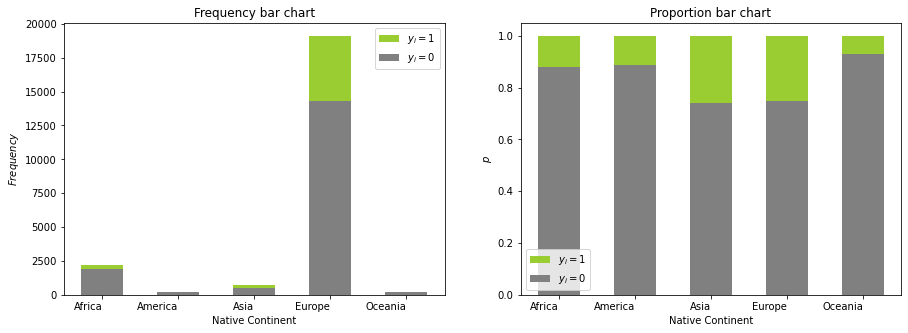

In [21]:
bar_charts_categorical(train, 'Native Continent', 'Income', 0)

### Discriminatory power of 'Marital Status'

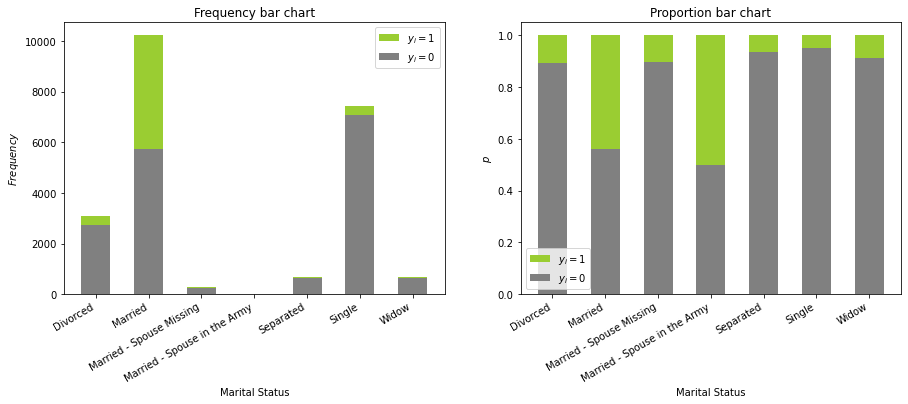

In [22]:
bar_charts_categorical(train, 'Marital Status', 'Income', 30)

### Discriminatory power of 'Lives with'

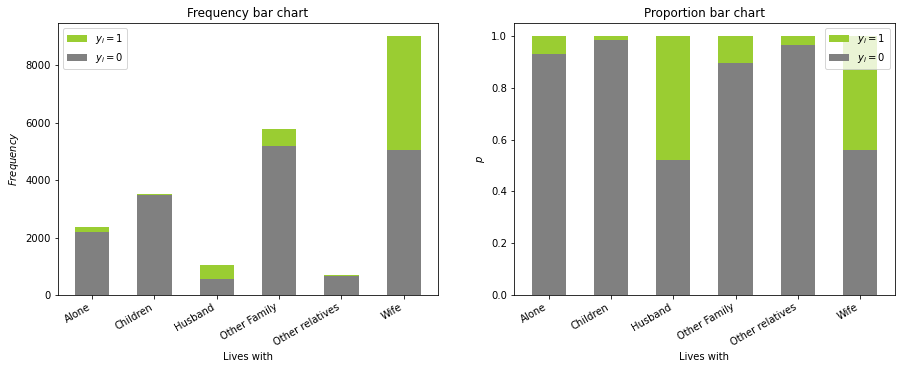

In [23]:
bar_charts_categorical(train, 'Lives with', 'Income', 30)

### Discriminatory power of 'Base Area'

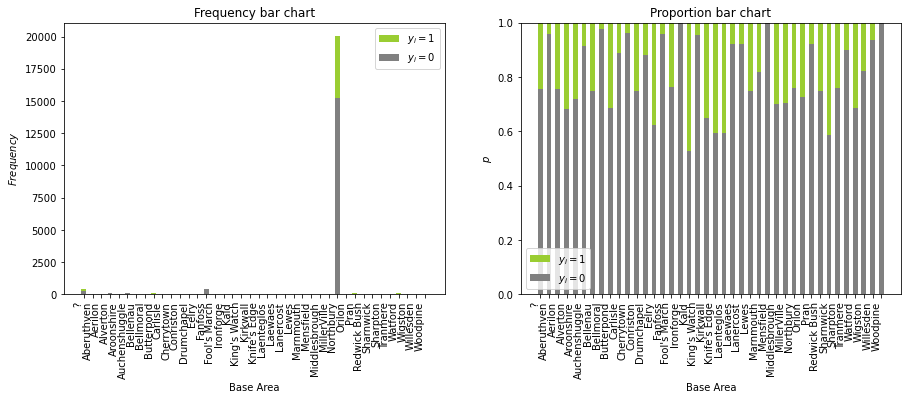

In [24]:
bar_charts_categorical(train, 'Base Area', 'Income', 90)

### Discriminatory power of 'Education Level'

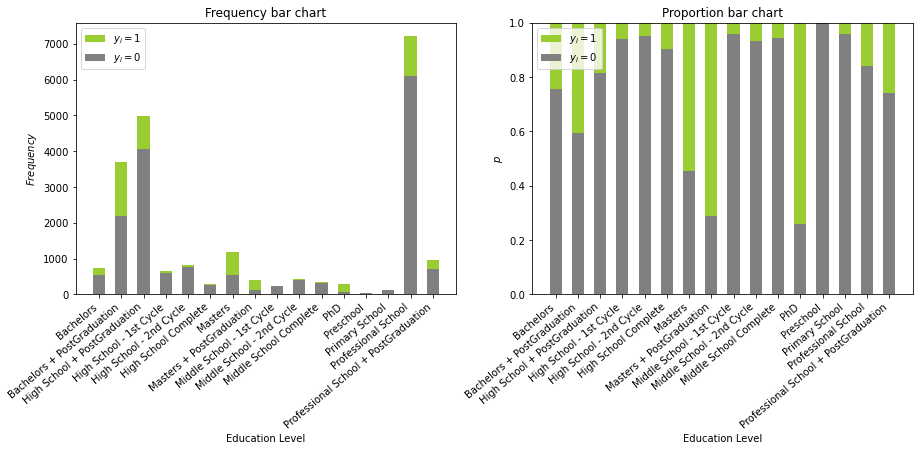

In [25]:
bar_charts_categorical(train, 'Education Level', 'Income', 40)

### Discriminatory power of  'Employment Sector'

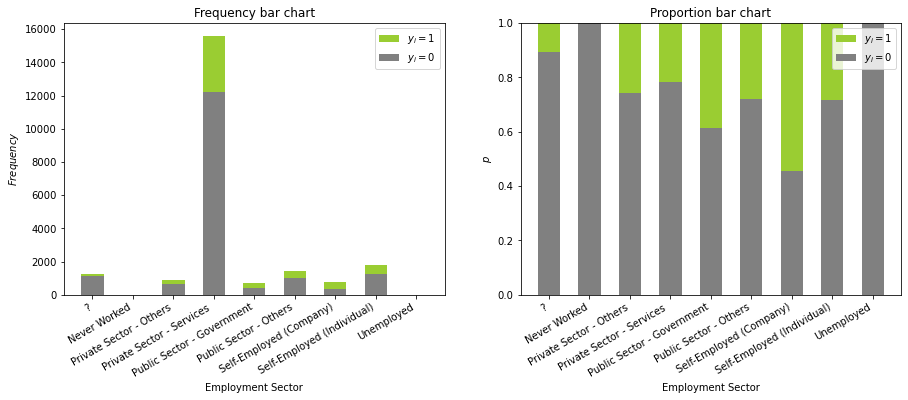

In [26]:
bar_charts_categorical(train, 'Employment Sector', 'Income', 30)

### Discriminatory power of  'Role'

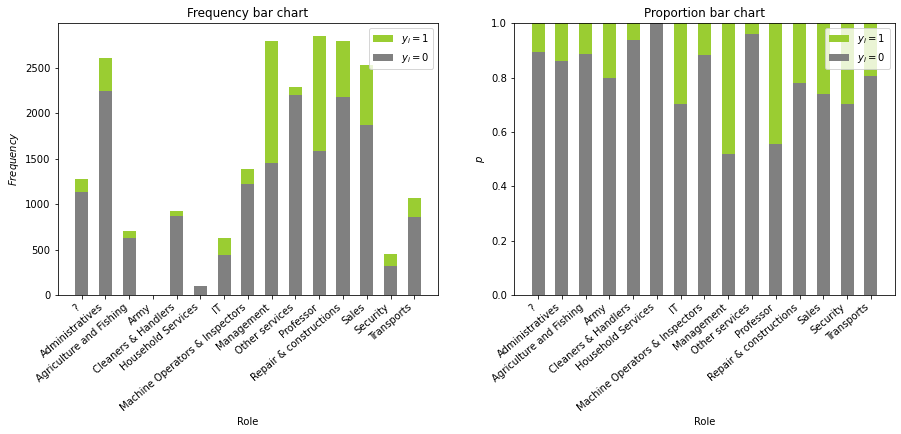

In [27]:
bar_charts_categorical(train, 'Role', 'Income', 40)

### Transform 'Ticket Price' into a binary variable and assess its discriminatory power

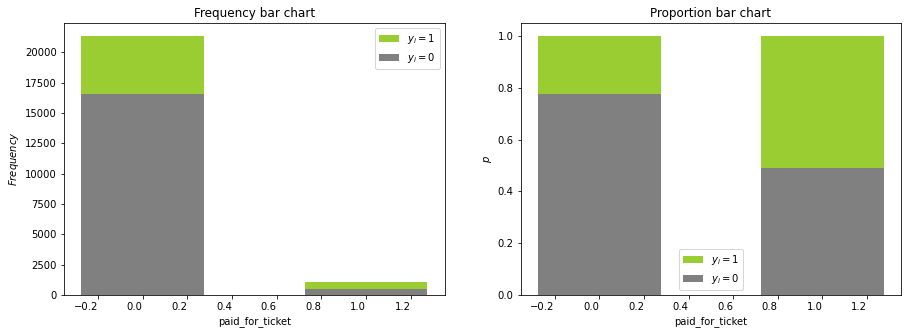

In [28]:
def make_binary(item):
    if item!=0:
        item=1
    return item

paid_for_ticket = train['Ticket Price'].map(lambda x:make_binary(x))
train_copy = train.copy()
train_copy.insert(loc=train_copy.shape[1]-1 , column='paid_for_ticket', value=paid_for_ticket)

bar_charts_categorical(train_copy, 'paid_for_ticket', 'Income', 0)

## One-hot encode categorical features
### One-hot encode 'Native Continent'

In [29]:
# Define a function that replaces a column by a set of columns
def replace_col(df, col_name, new_cols):
    df_copy = df.copy()
    col_index = df_copy.columns.get_loc(col_name)
    df_copy = df_copy.drop(columns=col_name)
    for col in range(new_cols.shape[1]):
        df_copy.insert(loc=col_index+col, column=list(new_cols)[col], value=new_cols.iloc[:,col])
    return df_copy    

In [30]:
# Define a function that one-hot encodes a column
def one_hot_encode(df, col_name, prefix):
    
    df_copy = df.copy()
    
    # Print the unique values to be one-hot encoded
    print('Unique values to be one-hot encoded:')
    print(pd.unique(df_copy[col_name]))
    
    # Compute dummy matrix
    y = pd.get_dummies(df_copy[col_name], prefix=prefix, dtype=float)
    
    if False:
        # Keeping all five variables would lead to one column being exactly the negation of the sum of the 
        # other columns. Show this:
        a = y.iloc[:,0]
        for col in range(1, y.shape[1]-1):
            a_=y.iloc[:,col]
            a=a+a_
        b=y.iloc[:, y.shape[1]-1]
        print()
        print('Correlation matrix of the sum of the first n-1 dummy features with the n-th dummy feature:')
        print(np.corrcoef(a.values,b.values))
    
    # Discard the last dummy column because of this (See code block above)
    y = y.drop(list(y)[y.shape[1]-1], axis=1)
    
    # Print the column that was discarded
    print()
    print('Column dropped (Case for which all dummy values = 0):')
    print(list(y)[y.shape[1]-1])
    
    # Use 'replace_col'
    df_copy = replace_col(df_copy, col_name, y)
    
    # Return the result
    return df_copy

In [31]:
# Use 'one_hot_encode' on 'Native Continent'
train_3 = one_hot_encode(train_2, 'Native Continent', 'Native_Continent')

Unique values to be one-hot encoded:
['Europe' 'Africa' 'Asia' 'America' 'Oceania']

Column dropped (Case for which all dummy values = 0):
Native_Continent_Europe


In [32]:
# Print the column labels of the resulting dataframe
list(train_3)

['CITIZEN_ID',
 'Name',
 'Age_days_rel_to_2020',
 'Native_Continent_Africa',
 'Native_Continent_America',
 'Native_Continent_Asia',
 'Native_Continent_Europe',
 'Marital Status',
 'Lives with',
 'Base Area',
 'Education Level',
 'Years of Education',
 'Employment Sector',
 'Role',
 'Working Hours per week',
 'Money Received',
 'Ticket Price',
 'Income']

In [33]:
# Use 'one_hot_encode' on 'Marital Status'
train_4 = one_hot_encode(train_3, 'Marital Status', 'Marital_Status')

Unique values to be one-hot encoded:
['Married' 'Single' 'Married - Spouse Missing' 'Divorced' 'Separated'
 'Widow' 'Married - Spouse in the Army']

Column dropped (Case for which all dummy values = 0):
Marital_Status_Single


In [34]:
# Print the column labels of the resulting dataframe
list(train_4)

['CITIZEN_ID',
 'Name',
 'Age_days_rel_to_2020',
 'Native_Continent_Africa',
 'Native_Continent_America',
 'Native_Continent_Asia',
 'Native_Continent_Europe',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Married - Spouse Missing',
 'Marital_Status_Married - Spouse in the Army',
 'Marital_Status_Separated',
 'Marital_Status_Single',
 'Lives with',
 'Base Area',
 'Education Level',
 'Years of Education',
 'Employment Sector',
 'Role',
 'Working Hours per week',
 'Money Received',
 'Ticket Price',
 'Income']

In [35]:
# Use 'one_hot_encode' on 'Lives with'
train_5 = one_hot_encode(train_4, 'Lives with', 'Lives_with')

Unique values to be one-hot encoded:
['Wife' 'Other Family' 'Children' 'Other relatives' 'Alone' 'Husband']

Column dropped (Case for which all dummy values = 0):
Lives_with_Other relatives


In [36]:
# Print the column labels of the resulting dataframe
list(train_5)

['CITIZEN_ID',
 'Name',
 'Age_days_rel_to_2020',
 'Native_Continent_Africa',
 'Native_Continent_America',
 'Native_Continent_Asia',
 'Native_Continent_Europe',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Married - Spouse Missing',
 'Marital_Status_Married - Spouse in the Army',
 'Marital_Status_Separated',
 'Marital_Status_Single',
 'Lives_with_Alone',
 'Lives_with_Children',
 'Lives_with_Husband',
 'Lives_with_Other Family',
 'Lives_with_Other relatives',
 'Base Area',
 'Education Level',
 'Years of Education',
 'Employment Sector',
 'Role',
 'Working Hours per week',
 'Money Received',
 'Ticket Price',
 'Income']

In [37]:
# Use 'one_hot_encode' on 'Base Area'
train_6 = one_hot_encode(train_5, 'Base Area', 'Base_Area')

Unique values to be one-hot encoded:
['Northbury' 'Auchenshuggle' 'Sharnwick' 'Laewaes' 'MillerVille' '?'
 'Fanfoss' 'Wigston' "Knife's Edge" 'Aerilon' 'Watford' 'Lanercost'
 'Bellmoral' 'Marnmouth' 'Bellenau' 'Butterpond' 'Laenteglos' 'Tranmere'
 'Eelry' 'Alverton' 'Pran' 'Willesden' "King's Watch" 'Kald' 'Kirkwall'
 "Fool's March" 'Middlesbrough' 'Orilon' 'Aroonshire' 'Aberuthven'
 'Sharpton' 'Lewes' 'Mensfield' 'Cherrytown' 'Redwick Bush' 'Drumchapel'
 'Carlisle' 'Conriston' 'Woodpine' 'Ironforge']

Column dropped (Case for which all dummy values = 0):
Base_Area_Willesden


In [38]:
# Print the column labels of the resulting dataframe
list(train_6)

['CITIZEN_ID',
 'Name',
 'Age_days_rel_to_2020',
 'Native_Continent_Africa',
 'Native_Continent_America',
 'Native_Continent_Asia',
 'Native_Continent_Europe',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Married - Spouse Missing',
 'Marital_Status_Married - Spouse in the Army',
 'Marital_Status_Separated',
 'Marital_Status_Single',
 'Lives_with_Alone',
 'Lives_with_Children',
 'Lives_with_Husband',
 'Lives_with_Other Family',
 'Lives_with_Other relatives',
 'Base_Area_?',
 'Base_Area_Aberuthven',
 'Base_Area_Aerilon',
 'Base_Area_Alverton',
 'Base_Area_Aroonshire',
 'Base_Area_Auchenshuggle',
 'Base_Area_Bellenau',
 'Base_Area_Bellmoral',
 'Base_Area_Butterpond',
 'Base_Area_Carlisle',
 'Base_Area_Cherrytown',
 'Base_Area_Conriston',
 'Base_Area_Drumchapel',
 'Base_Area_Eelry',
 'Base_Area_Fanfoss',
 "Base_Area_Fool's March",
 'Base_Area_Ironforge',
 'Base_Area_Kald',
 "Base_Area_King's Watch",
 'Base_Area_Kirkwall',
 "Base_Area_Knife's Edge",
 'Base_Area_La

In [39]:
# Use 'one_hot_encode' on 'Education Level'
# train_7 = one_hot_encode(train_6, 'Education Level', 'Education_Level')

In [40]:
# Print the column labels of the resulting dataframe
# list(train_7)

In [41]:
# Use 'one_hot_encode' on 'Employment Sector'
train_7 = one_hot_encode(train_6, 'Employment Sector', 'Employment_Sector')

Unique values to be one-hot encoded:
['Private Sector - Services ' 'Public Sector - Others'
 'Self-Employed (Individual)' 'Private Sector - Others' '?'
 'Self-Employed (Company)' 'Public Sector - Government' 'Unemployed'
 'Never Worked']

Column dropped (Case for which all dummy values = 0):
Employment_Sector_Self-Employed (Individual)


In [42]:
# Print the column labels of the resulting dataframe
list(train_7)

['CITIZEN_ID',
 'Name',
 'Age_days_rel_to_2020',
 'Native_Continent_Africa',
 'Native_Continent_America',
 'Native_Continent_Asia',
 'Native_Continent_Europe',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Married - Spouse Missing',
 'Marital_Status_Married - Spouse in the Army',
 'Marital_Status_Separated',
 'Marital_Status_Single',
 'Lives_with_Alone',
 'Lives_with_Children',
 'Lives_with_Husband',
 'Lives_with_Other Family',
 'Lives_with_Other relatives',
 'Base_Area_?',
 'Base_Area_Aberuthven',
 'Base_Area_Aerilon',
 'Base_Area_Alverton',
 'Base_Area_Aroonshire',
 'Base_Area_Auchenshuggle',
 'Base_Area_Bellenau',
 'Base_Area_Bellmoral',
 'Base_Area_Butterpond',
 'Base_Area_Carlisle',
 'Base_Area_Cherrytown',
 'Base_Area_Conriston',
 'Base_Area_Drumchapel',
 'Base_Area_Eelry',
 'Base_Area_Fanfoss',
 "Base_Area_Fool's March",
 'Base_Area_Ironforge',
 'Base_Area_Kald',
 "Base_Area_King's Watch",
 'Base_Area_Kirkwall',
 "Base_Area_Knife's Edge",
 'Base_Area_La

In [43]:
# Use 'one_hot_encode' on 'Role'
train_8 = one_hot_encode(train_7, 'Role', 'Role')

Unique values to be one-hot encoded:
['Repair & constructions' 'Sales' 'Security' 'Professor'
 'Cleaners & Handlers' 'Other services' 'Machine Operators & Inspectors'
 'Management' 'Administratives' 'Transports' '?' 'Agriculture and Fishing'
 'IT' 'Household Services' 'Army']

Column dropped (Case for which all dummy values = 0):
Role_Security


In [44]:
# Print the column labels of the resulting dataframe
list(train_8)

['CITIZEN_ID',
 'Name',
 'Age_days_rel_to_2020',
 'Native_Continent_Africa',
 'Native_Continent_America',
 'Native_Continent_Asia',
 'Native_Continent_Europe',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Married - Spouse Missing',
 'Marital_Status_Married - Spouse in the Army',
 'Marital_Status_Separated',
 'Marital_Status_Single',
 'Lives_with_Alone',
 'Lives_with_Children',
 'Lives_with_Husband',
 'Lives_with_Other Family',
 'Lives_with_Other relatives',
 'Base_Area_?',
 'Base_Area_Aberuthven',
 'Base_Area_Aerilon',
 'Base_Area_Alverton',
 'Base_Area_Aroonshire',
 'Base_Area_Auchenshuggle',
 'Base_Area_Bellenau',
 'Base_Area_Bellmoral',
 'Base_Area_Butterpond',
 'Base_Area_Carlisle',
 'Base_Area_Cherrytown',
 'Base_Area_Conriston',
 'Base_Area_Drumchapel',
 'Base_Area_Eelry',
 'Base_Area_Fanfoss',
 "Base_Area_Fool's March",
 'Base_Area_Ironforge',
 'Base_Area_Kald',
 "Base_Area_King's Watch",
 'Base_Area_Kirkwall',
 "Base_Area_Knife's Edge",
 'Base_Area_La

## Encoding 'Education Level'
**With 'Education Level' One-Hot Encoding is not appropriate since there is a meaningful order to the different levels of education**

In [45]:
# Creating a classification for the education level. First we'll check the values
set(list(train_8['Education Level']))

{'Bachelors',
 'Bachelors + PostGraduation',
 'High School + PostGraduation',
 'High School - 1st Cycle',
 'High School - 2nd Cycle',
 'High School Complete',
 'Masters',
 'Masters + PostGraduation',
 'Middle School - 1st Cycle',
 'Middle School - 2nd Cycle',
 'Middle School Complete',
 'PhD',
 'Preschool',
 'Primary School',
 'Professional School',
 'Professional School + PostGraduation'}

In [46]:
# Since the results represent a gradient and there are different levels of time investment in them we can classify
# them from lowest to largest

# Create a dictionary with the classification according to 'National Center for Education Statistics'
edu_classification = {1 : 'Preschool',
                      2 : 'Primary School',
                      3 : 'Middle School - 1st Cycle',
                      4 : 'Middle School - 2nd Cycle',
                      5 : 'Middle School Complete',
                      6 : 'High School - 1st Cycle',
                      7 : 'High School - 2nd Cycle',
                      8 : 'Professional School',
                      9 : 'High School Complete',
                      10 : 'Professional School + PostGraduation',
                      11 : 'High School + PostGraduation',
                      12 : 'Bachelors',
                      13 : 'Bachelors + PostGraduation',
                      14 : 'Masters',
                      15 : 'Masters + PostGraduation',
                      16 : 'PhD'
}

In [47]:
# Now we will create an auxiliar function that receives a level and assigns its corresponding classification 

def edu_classifier(level, classifier = edu_classification):
    """This funtion receives a level of education and a dictionary with education levels classification and returns
    the classification of a given level of education."""
    # List all the classifications in a specific order
    classif = list(edu_classification.keys())
    # List the education levels in the same order than the classifications
    edu_level = list(edu_classification.values())
    # Get the value where the given level's index does match in both lists
    return classif[edu_level.index(level)]

In [48]:
# Create a new column in the dataset using the classifications

# Apply 'edu_classifier' and convert the result to a single column dataframe
education_level_classified = train_8['Education Level'].apply(edu_classifier)
education_level_classified = education_level_classified.rename('Education_Level_Classified')
education_level_classified = pd.DataFrame(education_level_classified)

# Use 'replace_col'
train_9 = replace_col(train_8, 'Education Level', education_level_classified)

# Check the resulting new column
train_9[['Education_Level_Classified']].head()

,Education_Level_Classified
0,11
1,8
2,8
3,7
4,16


In [49]:
# Check all resulting column names
list(train_9)

['CITIZEN_ID',
 'Name',
 'Age_days_rel_to_2020',
 'Native_Continent_Africa',
 'Native_Continent_America',
 'Native_Continent_Asia',
 'Native_Continent_Europe',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Married - Spouse Missing',
 'Marital_Status_Married - Spouse in the Army',
 'Marital_Status_Separated',
 'Marital_Status_Single',
 'Lives_with_Alone',
 'Lives_with_Children',
 'Lives_with_Husband',
 'Lives_with_Other Family',
 'Lives_with_Other relatives',
 'Base_Area_?',
 'Base_Area_Aberuthven',
 'Base_Area_Aerilon',
 'Base_Area_Alverton',
 'Base_Area_Aroonshire',
 'Base_Area_Auchenshuggle',
 'Base_Area_Bellenau',
 'Base_Area_Bellmoral',
 'Base_Area_Butterpond',
 'Base_Area_Carlisle',
 'Base_Area_Cherrytown',
 'Base_Area_Conriston',
 'Base_Area_Drumchapel',
 'Base_Area_Eelry',
 'Base_Area_Fanfoss',
 "Base_Area_Fool's March",
 'Base_Area_Ironforge',
 'Base_Area_Kald',
 "Base_Area_King's Watch",
 'Base_Area_Kirkwall',
 "Base_Area_Knife's Edge",
 'Base_Area_La

In [50]:
train_encoded = train_9
train_encoded

,CITIZEN_ID,Name,Age_days_rel_to_2020,Native_Continent_Africa,Native_Continent_America,Native_Continent_Asia,Native_Continent_Europe,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Married - Spouse Missing,...,Role_Management,Role_Other services,Role_Professor,Role_Repair & constructions,Role_Sales,Role_Security,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,6360,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,40,0,2273,1
1,12487,Mr. Cameron McDonald,5421,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,40,0,0,1
2,12488,Mr. Keith Davidson,4220,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,46,0,2321,1
3,12489,Mr. Alexander Gill,13032,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,37,5395,0,1
4,12490,Mr. Neil Piper,2010,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,45,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22395,34881,Mrs. Lisa Alsop,-837,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,40,0,0,0
22396,34882,Mr. Julian Coleman,-1560,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,35,0,0,0
22397,34883,Miss Amelia Walker,-599,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,40,2674,0,0
22398,34884,Mr. Justin Sutherland,3458,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,90,0,0,1


## Feature Selection

In [51]:
train_encoded.corr()

,CITIZEN_ID,Age_days_rel_to_2020,Native_Continent_Africa,Native_Continent_America,Native_Continent_Asia,Native_Continent_Europe,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Married - Spouse Missing,Marital_Status_Married - Spouse in the Army,...,Role_Management,Role_Other services,Role_Professor,Role_Repair & constructions,Role_Sales,Role_Security,Working Hours per week,Money Received,Ticket Price,Income
CITIZEN_ID,1.000000,0.010138,0.003506,-0.003728,-0.006893,0.000847,-0.005248,0.004005,0.010529,-0.004138,...,-0.000908,0.003279,-0.002506,0.000831,-0.008645,0.004470,-0.006226,0.008200,-0.005254,-0.001914
Age_days_rel_to_2020,0.010138,1.000000,-0.025684,-0.008701,-0.011803,0.039511,0.135152,0.311321,0.012264,-0.010416,...,0.097680,-0.089084,0.048710,0.009079,-0.034292,0.004465,0.064918,0.072770,0.055792,0.233070
Native_Continent_Africa,0.003506,-0.025684,1.000000,-0.032684,-0.059035,-0.792901,0.015333,-0.131574,0.020530,-0.008226,...,-0.051451,0.086788,-0.047922,-0.046827,-0.029033,0.036517,-0.058433,-0.018898,-0.022299,-0.091428
Native_Continent_America,-0.003728,-0.008701,-0.032684,1.000000,-0.017833,-0.239520,0.014463,-0.018136,0.021182,-0.002485,...,-0.007337,0.000960,-0.012057,0.002298,-0.011100,-0.001292,-0.006343,-0.005958,-0.013225,-0.028723
Native_Continent_Asia,-0.006893,-0.011803,-0.059035,-0.017833,1.000000,-0.432622,-0.035724,0.015523,0.039329,-0.004488,...,-0.000995,0.012409,0.033210,-0.022702,-0.005662,-0.012887,-0.005338,0.012960,0.002866,0.009218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Role_Security,0.004470,0.004465,0.036517,-0.001292,-0.012887,-0.024206,-0.004361,0.033032,-0.010538,-0.003581,...,-0.054085,-0.048282,-0.054658,-0.054063,-0.051103,1.000000,0.026706,-0.007138,-0.000621,0.020428
Working Hours per week,-0.006226,0.064918,-0.058433,-0.006343,-0.005338,0.056703,0.031900,0.204864,-0.000980,-0.011230,...,0.137650,-0.159432,0.063207,0.056685,0.008407,0.026706,1.000000,0.075471,0.052959,0.219890
Money Received,0.008200,0.072770,-0.018898,-0.005958,0.012960,0.012312,-0.020187,0.085617,-0.004663,-0.001221,...,0.062633,-0.038512,0.081048,-0.023997,0.010553,-0.007138,0.075471,1.000000,-0.031330,0.221440
Ticket Price,-0.005254,0.055792,-0.022299,-0.013225,0.002866,0.023740,-0.027682,0.080798,-0.006742,-0.005457,...,0.045167,-0.040903,0.050977,0.000778,0.004487,-0.000621,0.052959,-0.031330,1.000000,0.155890


In [52]:
# Create a new correlation matrix with new features
new_metric_features_and_target = ['Age_days_rel_to_2020','Years of Education','Working Hours per week','Money Received','Ticket Price','Education_Level_Classified','Income']

In [53]:
# Compute the correlation matrix of 'train'
corr_pearson = train_encoded[new_metric_features_and_target].corr(method='pearson')
corr_spearman = train_encoded[new_metric_features_and_target].corr(method='spearman')

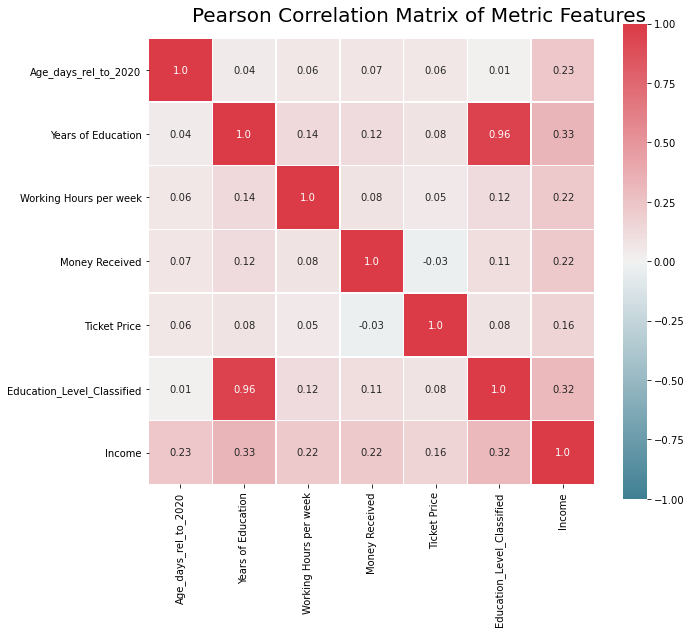

In [54]:
# Adapted from data mining lab 4:

# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Round the values of the correlation matrix
corr_rounded = np.round(corr_pearson, decimals=2)

# Build annotation matrix (values above |limit| will appear annotated in the plot)
limit=0.001
mask_annot = np.absolute(corr_rounded.values) >= limit
annot = np.where(mask_annot, corr_rounded.values, np.full(corr_rounded.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr_rounded, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Pearson Correlation Matrix of Metric Features", fontsize=20)

plt.show()

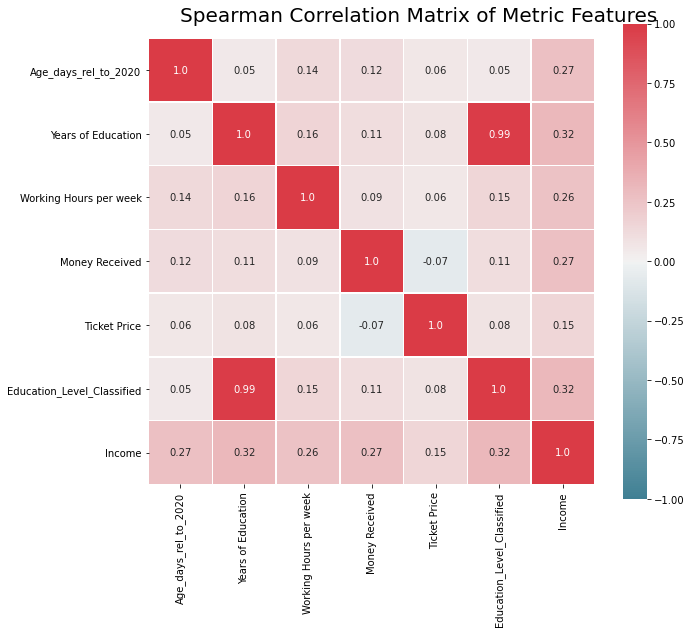

In [55]:
# Adapted from data mining lab 4:

# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Round the values of the correlation matrix
corr_rounded = np.round(corr_spearman, decimals=2)

# Build annotation matrix (values above |limit| will appear annotated in the plot)
limit=0.001
mask_annot = np.absolute(corr_rounded.values) >= limit
annot = np.where(mask_annot, corr_rounded.values, np.full(corr_rounded.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr_rounded, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Spearman Correlation Matrix of Metric Features", fontsize=20)

plt.show()

In [56]:
# Take a look at the columns we have
list(train_encoded)

['CITIZEN_ID',
 'Name',
 'Age_days_rel_to_2020',
 'Native_Continent_Africa',
 'Native_Continent_America',
 'Native_Continent_Asia',
 'Native_Continent_Europe',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Married - Spouse Missing',
 'Marital_Status_Married - Spouse in the Army',
 'Marital_Status_Separated',
 'Marital_Status_Single',
 'Lives_with_Alone',
 'Lives_with_Children',
 'Lives_with_Husband',
 'Lives_with_Other Family',
 'Lives_with_Other relatives',
 'Base_Area_?',
 'Base_Area_Aberuthven',
 'Base_Area_Aerilon',
 'Base_Area_Alverton',
 'Base_Area_Aroonshire',
 'Base_Area_Auchenshuggle',
 'Base_Area_Bellenau',
 'Base_Area_Bellmoral',
 'Base_Area_Butterpond',
 'Base_Area_Carlisle',
 'Base_Area_Cherrytown',
 'Base_Area_Conriston',
 'Base_Area_Drumchapel',
 'Base_Area_Eelry',
 'Base_Area_Fanfoss',
 "Base_Area_Fool's March",
 'Base_Area_Ironforge',
 'Base_Area_Kald',
 "Base_Area_King's Watch",
 'Base_Area_Kirkwall',
 "Base_Area_Knife's Edge",
 'Base_Area_La

In [57]:
# Check the actual dataset
train_encoded

,CITIZEN_ID,Name,Age_days_rel_to_2020,Native_Continent_Africa,Native_Continent_America,Native_Continent_Asia,Native_Continent_Europe,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Married - Spouse Missing,...,Role_Management,Role_Other services,Role_Professor,Role_Repair & constructions,Role_Sales,Role_Security,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,6360,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,40,0,2273,1
1,12487,Mr. Cameron McDonald,5421,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,40,0,0,1
2,12488,Mr. Keith Davidson,4220,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,46,0,2321,1
3,12489,Mr. Alexander Gill,13032,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,37,5395,0,1
4,12490,Mr. Neil Piper,2010,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,45,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22395,34881,Mrs. Lisa Alsop,-837,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,40,0,0,0
22396,34882,Mr. Julian Coleman,-1560,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,35,0,0,0
22397,34883,Miss Amelia Walker,-599,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,40,2674,0,0
22398,34884,Mr. Justin Sutherland,3458,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,90,0,0,1


In [58]:
# Separate our data and target

# Exclude the id and the name
train_data = train_encoded.drop(columns = {'Income'}).iloc[:, 2:]

# Include only the target
train_target = train_encoded['Income']

#### Based on the discriminatory analysis made above we can also try to remove some variable on a first approach and check the results.

We will for now remove 'Native Continent' related variables and the same for 'Base Area' since there doesn't seem to be much influence on the target variable caused by these two.

In [59]:
# Create a list with the columns to remove
columns_to_remove = ['Native_Continent_Africa',
 'Native_Continent_America',
 'Native_Continent_Asia',
 'Native_Continent_Europe','Base_Area_?',
 'Base_Area_Aberuthven',
 'Base_Area_Aerilon',
 'Base_Area_Alverton',
 'Base_Area_Aroonshire',
 'Base_Area_Auchenshuggle',
 'Base_Area_Bellenau',
 'Base_Area_Bellmoral',
 'Base_Area_Butterpond',
 'Base_Area_Carlisle',
 'Base_Area_Cherrytown',
 'Base_Area_Conriston',
 'Base_Area_Drumchapel',
 'Base_Area_Eelry',
 'Base_Area_Fanfoss',
 "Base_Area_Fool's March",
 'Base_Area_Ironforge',
 'Base_Area_Kald',
 "Base_Area_King's Watch",
 'Base_Area_Kirkwall',
 "Base_Area_Knife's Edge",
 'Base_Area_Laenteglos',
 'Base_Area_Laewaes',
 'Base_Area_Lanercost',
 'Base_Area_Lewes',
 'Base_Area_Marnmouth',
 'Base_Area_Mensfield',
 'Base_Area_Middlesbrough',
 'Base_Area_MillerVille',
 'Base_Area_Northbury',
 'Base_Area_Orilon',
 'Base_Area_Pran',
 'Base_Area_Redwick Bush',
 'Base_Area_Sharnwick',
 'Base_Area_Sharpton',
 'Base_Area_Tranmere',
 'Base_Area_Watford',
 'Base_Area_Wigston',
 'Base_Area_Willesden',
]

# Remove the columns
train_data.drop(columns = columns_to_remove, inplace = True)

# Add the 'Income' variable for correlation checking purposes
correlate_data = train_data
correlate_data['Target'] = train_target

In [60]:
# Compute the correlation matrix of 'train_data'
corr_pearson = correlate_data.corr(method='pearson')

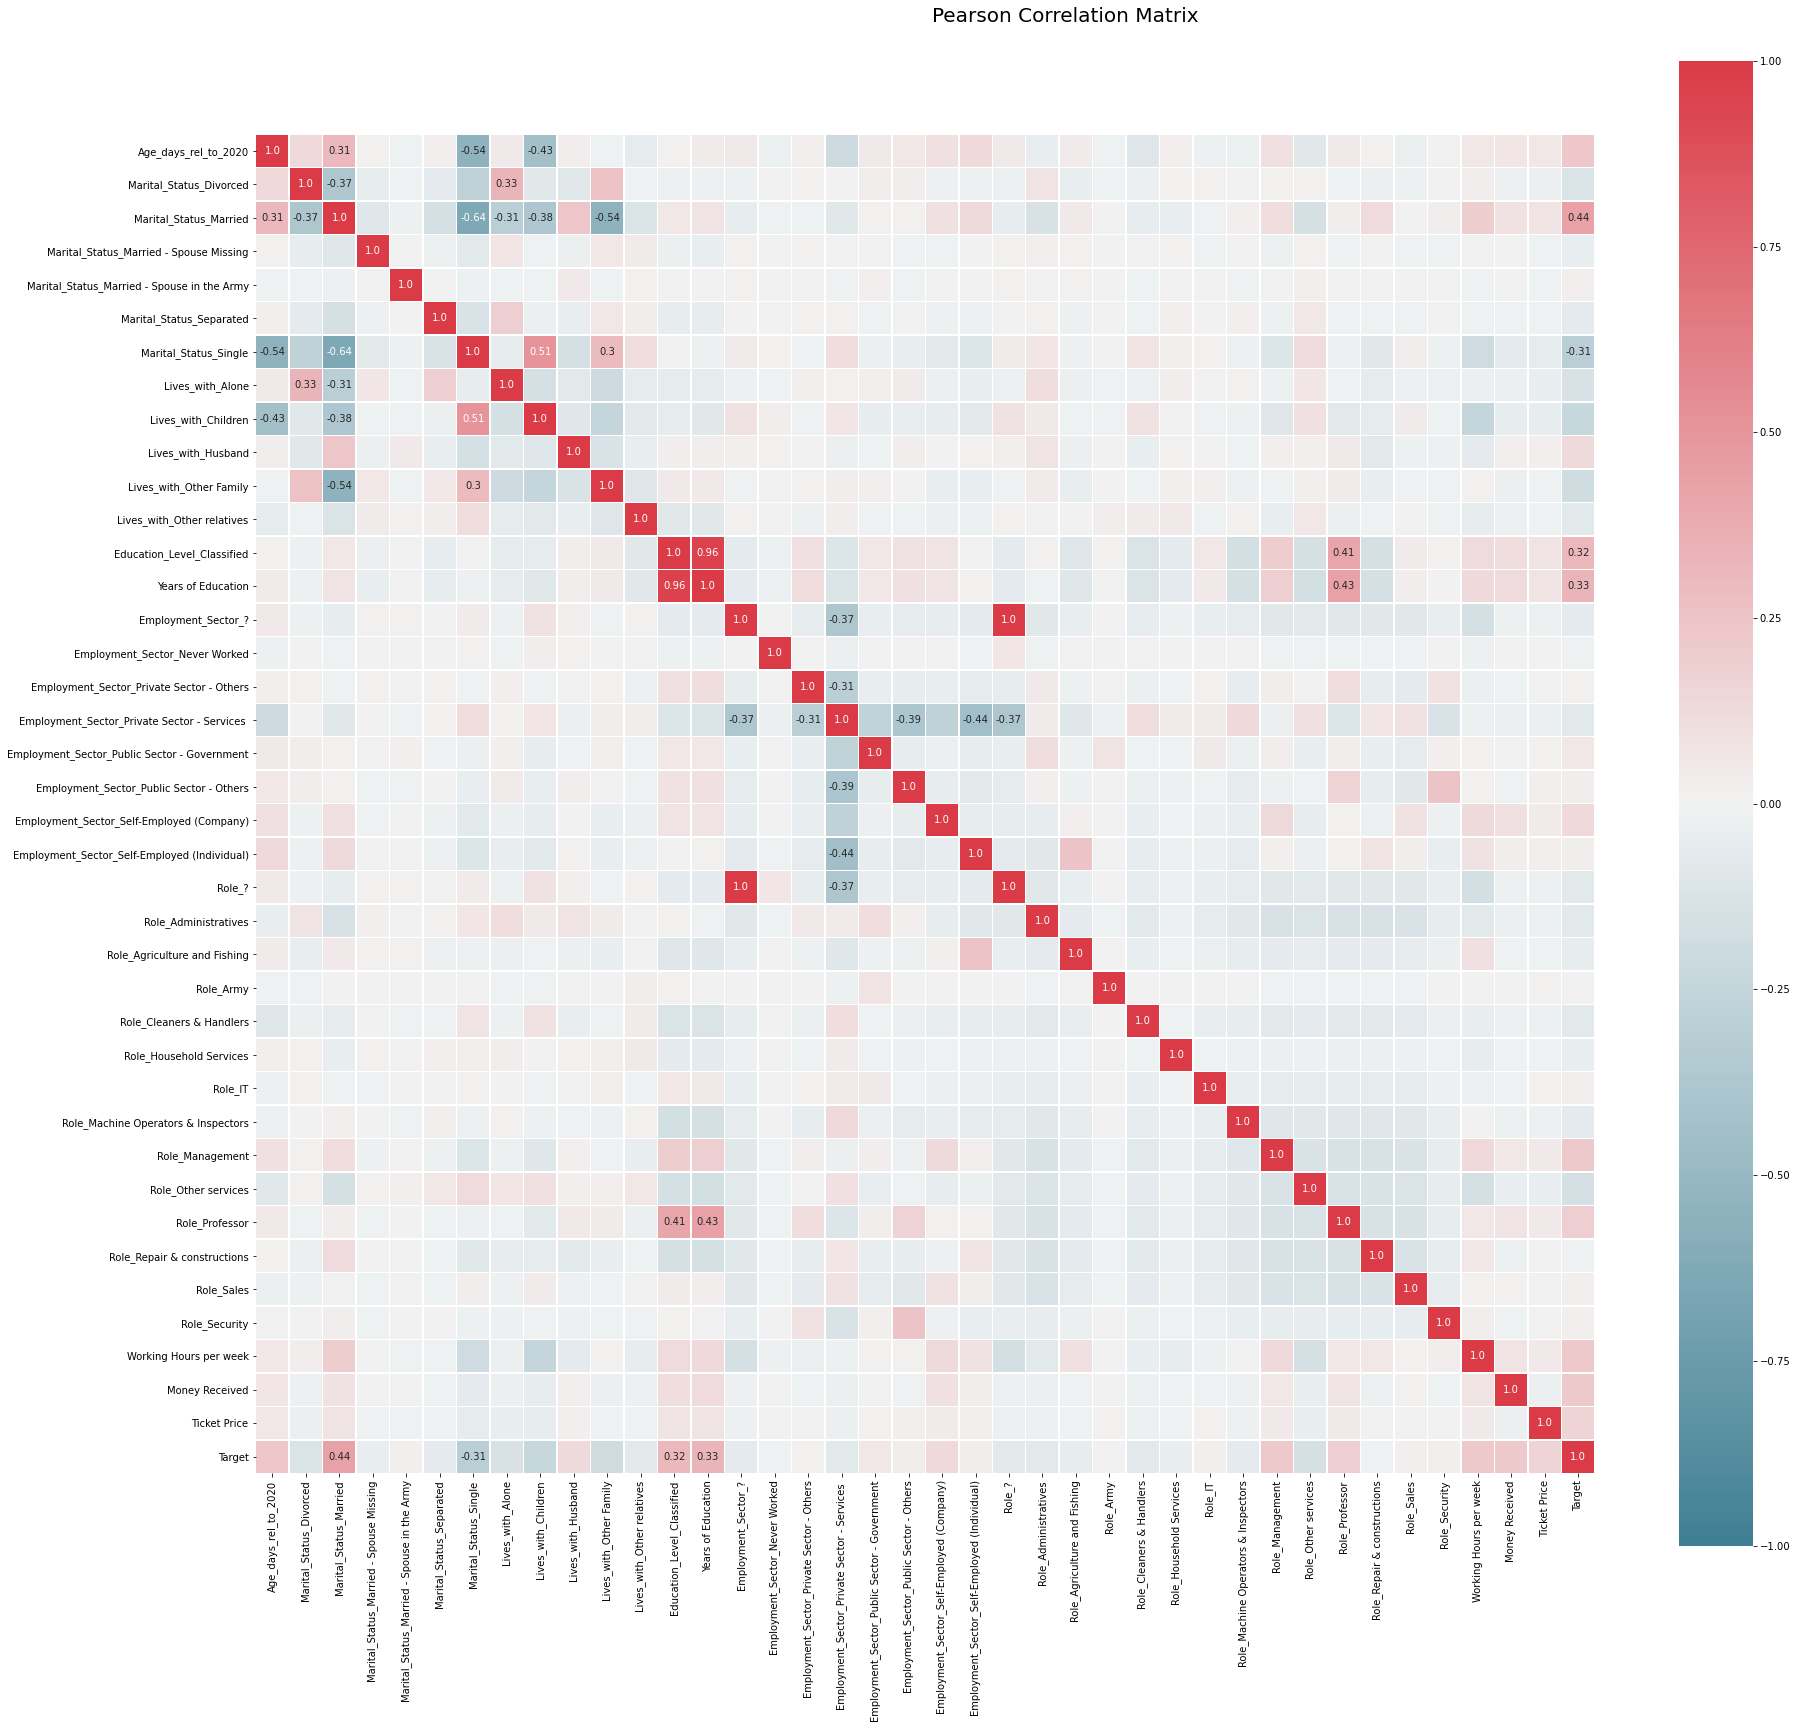

In [61]:
# Adapted from data mining lab 4:

# Prepare figure
fig = plt.figure(figsize=(30, 25))

# Round the values of the correlation matrix
corr_rounded = np.round(corr_pearson, decimals=2)

# Build annotation matrix (values above |limit| will appear annotated in the plot)
limit=0.3
mask_annot = np.absolute(corr_rounded.values) >= limit
annot = np.where(mask_annot, corr_rounded.values, np.full(corr_rounded.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr_rounded, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Pearson Correlation Matrix", fontsize=20)

plt.show()

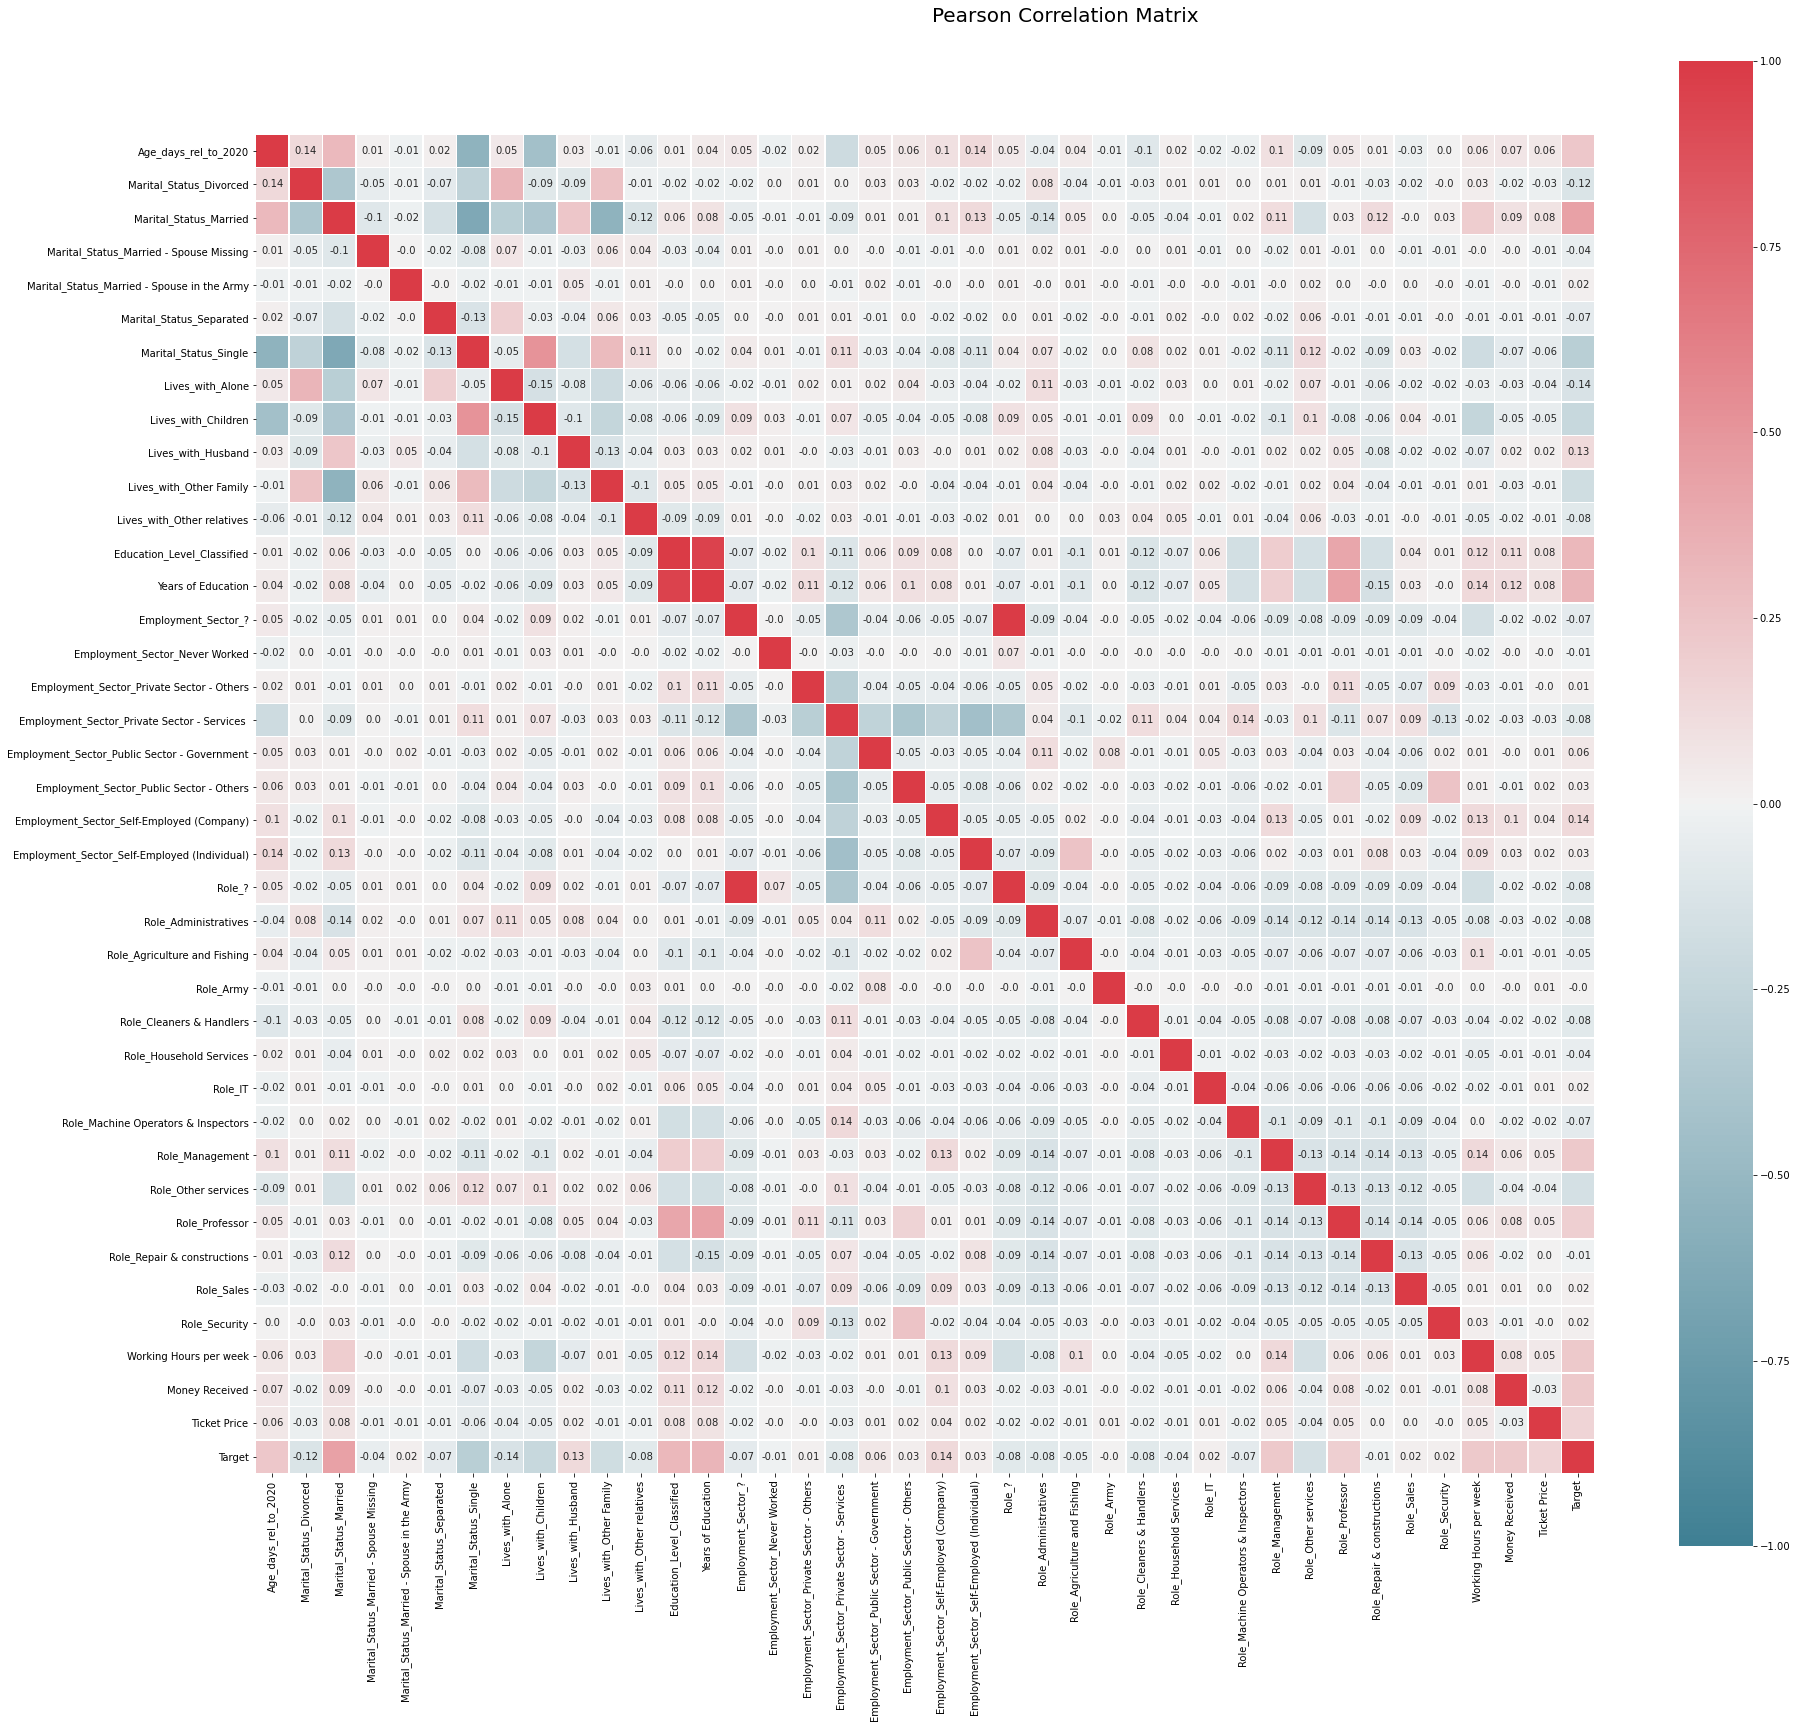

In [62]:
# Adapted from data mining lab 4:

# Prepare figure
fig = plt.figure(figsize=(30, 25))

# Round the values of the correlation matrix
corr_rounded = np.round(corr_pearson, decimals=2)

# Build annotation matrix (values above |limit| will appear annotated in the plot)
limit=0.15
mask_annot = np.absolute(corr_rounded.values) <= limit
annot = np.where(mask_annot, corr_rounded.values, np.full(corr_rounded.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr_rounded, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Pearson Correlation Matrix", fontsize=20)

plt.show()

From the analysis of the 2 plots above we can always remove one of two highly correlated features, in order not to bring redundancy to our model.

High Correlations:
1. Role_? / Employment_Sector_? --> corr = 1
2. Years_of_Education / Edu_Level_Classified --> corr = 0.96
3. Marital_Status_Married / Marital_Status_Single --> corr = -0.64

From these pairs we'll try keeping:
1. Role - It has higher correlation to our target variable
2. Edu_Level_Classified - It is more clearly informative and accurate
3. Marital_Status_Married - It has higher correlation to our target variable

At this point we're also eliminating features that have a correlation to the target lower than 0.15.

As a result of this, we end up with 11 features.

In [63]:
# Create a list with the features to keep now
features_to_keep_1 = ['Age_days_rel_to_2020',
                     'Marital_Status_Married',
                     'Lives_with_Children',
                     'Lives_with_Other Family',
                     'Role_Management',
                     'Role_Other services',
                     'Role_Professor',
                     'Working Hours per week',
                     'Money Received',
                     'Ticket Price',
                     'Education_Level_Classified']

In [64]:
# Cretate a dataset with those features
train_data_selected = train_data[features_to_keep_1]

# Performing feature selection with RFE 

In [65]:
if False:
    # Create a linear regression to apply to our data
    linear_reg = LinearRegression()

    # Create an RFE instance with our linear regression and for 10 features
    rfe = RFE(estimator = linear_reg, n_features_to_select = 11)

    # Transform the data 
    X_rfe = rfe.fit_transform(X = train_data_selected, y = train_target)

    # Fit our linear regression to our data
    linear_reg.fit(X_rfe, y = train_target)

In [66]:
if False:
    # Check which variable did our model select as most important
    rfe.support_

In [67]:
if False:
    # Ranking created by RFE for our features
    rfe.ranking_

In [68]:
if False:
    # See the results in a dataframe
    selected_features = pd.DataFrame(rfe.support_, index = train_data.columns)
    selected_features.columns = ['Important']
    selected_features

    # Filter for 'Important' = True
    selected_features[selected_features['Important'] == True]

In [69]:
if False:
    # Since we don't know apriori the appropriate number of features we will use this code adapted from feature selection
    # machine learning lab

    #no of features
    nof_list=np.arange(1,13)            
    high_score=0
    #Variable to store the optimum features
    nof=0           
    score_list =[]
    for n in range(len(nof_list)):
        # we are going to see in the next class this "train_test_split()"...
        X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size = 0.3, random_state = 0)

        model = LinearRegression()
        rfe = RFE(model,nof_list[n])
        X_train_rfe = rfe.fit_transform(X_train,y_train)
        X_test_rfe = rfe.transform(X_test)
        model.fit(X_train_rfe,y_train)

        score = model.score(X_test_rfe,y_test)
        score_list.append(score)

        if(score>high_score):
            high_score = score
            nof = nof_list[n]
    print("Optimum number of features: %d" %nof)
    print("Score with %d features: %f" % (nof, high_score))

## Outlier detection

Features that could potentially have outliers:
'Age_days_rel_to_2020',
'Working Hours per week',
'Money Received' and
'Ticket Price'.

The other remaining features are encoded categorical features.

### 'Age_days_rel_to_2020'

In [70]:
# Show the age of the oldest and the youngest person in the data set
# The oldest person in the dataset is born somewhere around 1958 and the youngest person in the dataset is born 
# somewhere around 2031
print('Maximum and minimum of ages (roughly) in years:')
print(train_data_selected['Age_days_rel_to_2020'].max()/365)
print(train_data_selected['Age_days_rel_to_2020'].min()/365)

# Check that this makes sense by printing the birthdays of the oldest and of the youngest person in the data set (We 
# saved all birthdays in a previous step)
print()
print('Minimum and Maximum of birthdays:')
print(birthdays.min())
print(birthdays.max())

Maximum and minimum of ages (roughly) in years:
62.95068493150685
-10.873972602739727

Minimum and Maximum of birthdays:
1958-01-01
2031-10-11


**All values for 'Age_days_rel_to_2020' seem to be reasonable. No need to remove any outliers.**

### 'Working Hours per week'

In [71]:
print("Maximum and minimum of 'Working Hours per week':")
print(train_data_selected['Working Hours per week'].max())
print(train_data_selected['Working Hours per week'].min())

Maximum and minimum of 'Working Hours per week':
99
1


**One week has 24*7=168 hours. So, it is logially possible to work 99 hours.**

**Let's assume this person works every day. 99 hours divided by 7 is 14 hours. This would mean that 10 hours are left for sleeping and other activities. This could also be the case.**

**Let's assume this person works six days a week. 99 hours divided by 6 is 16.5 hours. This would mean that 7.5 hours are left for sleeping and other activities. For certain people (that either need little sleep or have no free time on work days), this could also be the case.**

**Conclusion: All values for 'Working Hours per week' seem to be reasonable. No need to remove any outliers.**

### 'Money Received'

In [72]:
print("Maximum and minimum of 'Money Received':")
print(train_data_selected['Money Received'].max())
print(train_data_selected['Money Received'].min())

Maximum and minimum of 'Money Received':
122999
0


**No negative values for 'Money Received'. No extremely high values either. No need to remove any outliers.**

### 'Ticket Price'

In [73]:
print("Maximum and minimum of 'Ticket Price':")
print(train_data_selected['Ticket Price'].max())
print(train_data_selected['Ticket Price'].min())

Maximum and minimum of 'Ticket Price':
5358
0


**No negative values for 'Ticket Price'. No extremely high values either. No need to remove any outliers.**

## Feature Scaling

In [74]:
train_data_selected

,Age_days_rel_to_2020,Marital_Status_Married,Lives_with_Children,Lives_with_Other Family,Role_Management,Role_Other services,Role_Professor,Working Hours per week,Money Received,Ticket Price,Education_Level_Classified
0,6360,1.0,0.0,0.0,0.0,0.0,0.0,40,0,2273,11
1,5421,1.0,0.0,0.0,0.0,0.0,0.0,40,0,0,8
2,4220,1.0,0.0,0.0,0.0,0.0,0.0,46,0,2321,8
3,13032,1.0,0.0,0.0,0.0,0.0,0.0,37,5395,0,7
4,2010,0.0,0.0,1.0,0.0,0.0,1.0,45,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...
22395,-837,0.0,1.0,0.0,0.0,0.0,0.0,40,0,0,8
22396,-1560,0.0,1.0,0.0,0.0,1.0,0.0,35,0,0,8
22397,-599,0.0,0.0,1.0,0.0,0.0,1.0,40,2674,0,14
22398,3458,0.0,0.0,1.0,0.0,0.0,0.0,90,0,0,13


In [75]:
train_target

0        1
1        1
2        1
3        1
4        1
        ..
22395    0
22396    0
22397    0
22398    1
22399    0
Name: Income, Length: 22400, dtype: int64

In [76]:
# Use 'MinMaxScaler' to scale the selected features to [0,1]
mmscaler = MinMaxScaler()
train_data_selected_scaled = pd.DataFrame(mmscaler.fit_transform(train_data_selected), columns=train_data_selected.columns)

In [77]:
# Check the result of the scaling
print('Minima:')
print(train_data_selected_scaled.min())
print()
print('Maxima:')
print(train_data_selected_scaled.max())

Minima:
Age_days_rel_to_2020          0.0
Marital_Status_Married        0.0
Lives_with_Children           0.0
Lives_with_Other Family       0.0
Role_Management               0.0
Role_Other services           0.0
Role_Professor                0.0
Working Hours per week        0.0
Money Received                0.0
Ticket Price                  0.0
Education_Level_Classified    0.0
dtype: float64

Maxima:
Age_days_rel_to_2020          1.0
Marital_Status_Married        1.0
Lives_with_Children           1.0
Lives_with_Other Family       1.0
Role_Management               1.0
Role_Other services           1.0
Role_Professor                1.0
Working Hours per week        1.0
Money Received                1.0
Ticket Price                  1.0
Education_Level_Classified    1.0
dtype: float64


## Model selection
### Use stratified k-fold cross validation to find a good model
**For this, define a function that applies stratified k-fold cross validation on a given model and data set and computes the average accuracy.**

**Then, initialise different models and use the function on them.**

In [125]:
# Adapted from Machine Learning lab 'Neural Networks Parameters'
def avg_score(model, data, target, model_name):
    """Function to apply a model and compute the average accuracy by using k-fold cross validation"""
    
    # Create an instance of 'StratifiedKFold' with 10 splits
    kf_stratified = StratifiedKFold(n_splits=10)

    # Create lists to store the results from the different splits 
    score_train = []
    score_validation = []
    
    timer = []
    #n_iter = []
    
    for train_index, validation_index in kf_stratified.split(data, target):
        
        # get the indexes of the observations assigned for each partition
        X_train, X_validation = data.iloc[train_index], data.iloc[validation_index]
        y_train, y_validation = target.iloc[train_index], target.iloc[validation_index]
        
        # Start counting time
        begin = time.perf_counter()
        
        # fit the model to the data
        model.fit(X_train, y_train)
        
        # Finish counting time
        end = time.perf_counter()
        
        # Get the mean accuracy for the training set
        value_train = model.score(X_train, y_train)
        
        # Get the mean accuracy for the validation set
        value_validation = model.score(X_validation, y_validation)
        
        # Append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_validation.append(value_validation)
        
        timer.append(end-begin)
        
        # n_iter.append(model.n_iter_)
    
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),2)
    avg_train = round(np.mean(score_train),4)
    avg_validation = round(np.mean(score_validation),4)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),6)
    std_validation = round(np.std(score_validation),6)
    # avg_iter = round(np.mean(n_iter),1)
    # std_iter = round(np.std(n_iter),1)
    
    return pd.DataFrame({'Avg. train score':[avg_train], 'Std. dev. train score':[std_train],
                         'Avg. validation score':[avg_validation], 'Std. dev. validation score':[std_validation],
                        'Avg. time':[avg_time], 'Std. dev. time':[std_time]},
                        index=[model_name]), score_train, score_validation, timer

# Create a dataframe for results
models_results = pd.DataFrame(columns=['Avg. train score','Std. dev. train score','Avg. validation score','Std. dev. validation score',
                      'Avg. time','Std. dev. time'])

### MLP classifier

In [79]:
# Initialise an MLP Classifier
model = MLPClassifier()

# Use 'avg_score' to apply k-fold cross validation
MLP_result, MLP_score_train, MLP_score_validation, MLP_timer = avg_score(model, train_data_selected_scaled, train_target, 'Multilayer perceptron', kf_stratified)

In [126]:
# Append result to 'models_results'
models_results = models_results.append(MLP_result)

### Gradient Boosting Classifier

In [82]:
# Initialise a Gradient Boosting classifier
model = GradientBoostingClassifier()

# Use 'avg_score' to apply k-fold cross validation
GBC_result, GBC_score_train, GBC_score_validation, GBC_timer = avg_score(model, train_data_selected_scaled, train_target, 'Gradient Boosting Classifier', kf_stratified)

In [127]:
# Append result to 'models_results'
models_results = models_results.append(GBC_result)

### XGB classifier

In [86]:
# Initialise an MLP classifier
model = XGBClassifier()

# Use 'avg_score' to apply k-fold cross validation
XGB_result, XGB_score_train, XGB_score_validation, XGB_timer = avg_score(model, train_data_selected_scaled, train_target, 'XGB Classifier', kf_stratified)

In [128]:
# Append result to 'models_results'
models_results = models_results.append(XGB_result)

### Ada Boost classifier

In [91]:
# Initialise an Ada Boost classifier
model = AdaBoostClassifier()

# Use 'avg_score' to apply k-fold cross validation
ABC_result, ABC_score_train, ABC_score_validation, ABC_timer = avg_score(model, train_data_selected_scaled, train_target, 'Ada Boost Classifier', kf_stratified)

In [129]:
# Append result to 'models_results'
models_results = models_results.append(ABC_result)

### Random Forest classifier

In [95]:
# Initialise a Random Forest classifier
model = RandomForestClassifier()

# Use 'avg_score' to apply k-fold cross validation
RFC_result, RFC_score_train, RFC_score_validation, RFC_timer = avg_score(model, train_data_selected_scaled, train_target, 'Random Forest Classifier', kf_stratified)

In [130]:
# Append result to 'models_results'
models_results = models_results.append(RFC_result)

### Extra Trees classifier

In [98]:
# Initialise an Extra Trees classifier
model = ExtraTreesClassifier()

# Use 'avg_score' to apply k-fold cross validation
ETC_result, ETC_score_train, ETC_score_validation, ETC_timer = avg_score(model, train_data_selected_scaled, train_target, 'Extra Trees Classifier', kf_stratified)

In [131]:
# Append result to 'models_results'
models_results = models_results.append(ETC_result)

In [132]:
models_results

,Avg. train score,Std. dev. train score,Avg. validation score,Std. dev. validation score,Avg. time,Std. dev. time
Multilayer perceptron,0.8511,0.000922,0.8487,0.006085,11.57,2.28
Gradient Boosting Classifier,0.8653,0.000700,0.8617,0.005186,1.95,0.33
XGB Classifier,0.8914,0.000961,0.8614,0.008220,1.29,0.17
Ada Boost Classifier,0.8577,0.000715,0.8569,0.007022,0.57,0.02
Random Forest Classifier,0.9983,0.000059,0.8304,0.006250,2.28,0.49
Extra Trees Classifier,0.9985,0.000095,0.8215,0.004839,1.82,0.21
